### Notebook overview
Calculate AR cost of storage over time

In [92]:
# libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests as r
import os
import json

In [93]:
# get working directory
wd_path = os.getcwd()

In [94]:
# get gecko api key from env variables
gecko_key = os.getenv("GECKO_API")

In [95]:
# get ar/usd price for a single day
# arweave token ID: arweave

url = 'https://api.coingecko.com/api/v3/coins/arweave/history?date=01-09-2023&localization=false'

headers = {
    'x-cg-demo-api-key': gecko_key
}

ar_historical_price_response = r.get(url, headers=headers)
print(ar_historical_price_response.status_code)
if ar_historical_price_response.status_code == 200:
    ar_historical_prices = ar_historical_price_response.text
else:
    print('coingecko api error')

200


In [96]:
# Parse the JSON string
data = json.loads(ar_historical_prices)

# get the ar/usd price result
data['market_data']['current_price']['usd']

4.131338009673593

In [97]:
# import txs csv to dataframe
df_transactions = pd.read_csv(f'{wd_path}/weave_txs.csv')

In [98]:
# drop duplicate blocks
# compare - start row count
print(df_transactions.shape[0])

# drop duplicates
df_transactions = df_transactions.drop_duplicates(subset=['hash'])

# compare - end row count
print(df_transactions.shape[0])


536852
522849


In [99]:
# convert to float
df_transactions.loc[:, 'ar_fee'] = df_transactions['ar_fee'].astype(float)
df_transactions.loc[:, 'data_size_bytes'] = df_transactions['data_size_bytes'].astype(float)

In [100]:
# filter txs w/zero or missing data size field

# compare - start row count
print(df_transactions.shape[0])

# drop
df_transactions = df_transactions[df_transactions['data_size_bytes']>0]
df_transactions.dropna(subset=['data_size_bytes'], inplace=True)

# compare - end row count
print(df_transactions.shape[0])

522849
501683


In [101]:
# calculate standardized cost fields
df_transactions['data_size_kb'] = df_transactions['data_size_bytes']/1024
df_transactions['data_size_mb'] = df_transactions['data_size_bytes']/(1024**2)
df_transactions['data_size_gb'] = df_transactions['data_size_bytes']/(1024**3)
df_transactions['ar_per_byte'] = df_transactions['ar_fee'] / df_transactions['data_size_bytes']
df_transactions['ar_per_kb'] = df_transactions['ar_fee'] / df_transactions['data_size_kb']
df_transactions['ar_per_mb'] = df_transactions['ar_fee'] / (df_transactions['data_size_bytes']/(1024**2))
df_transactions['ar_per_gb'] = df_transactions['ar_fee'] / (df_transactions['data_size_bytes']/(1024**3))
df_transactions['timestamp_dt'] = pd.to_datetime(df_transactions['timestamp'], unit='s')

# view results
print(df_transactions.info())
print(df_transactions.sort_values(by='height', ascending=False).head())
print(df_transactions.sort_values(by='height', ascending=True).head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501683 entries, 0 to 536851
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   hash             501683 non-null  object        
 1   height           501683 non-null  int64         
 2   timestamp        501683 non-null  int64         
 3   ar_fee           501683 non-null  float64       
 4   data_size_bytes  501683 non-null  float64       
 5   ar_per_mb        501683 non-null  float64       
 6   ar_per_gb        501683 non-null  float64       
 7   timestamp_dt     501683 non-null  datetime64[ns]
 8   data_size_kb     501683 non-null  float64       
 9   data_size_mb     501683 non-null  float64       
 10  data_size_gb     501683 non-null  float64       
 11  ar_per_byte      501683 non-null  float64       
 12  ar_per_kb        501683 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 53.6+ 

In [102]:
# calculate medians by block
# order descending by block height
df_compute = df_transactions.groupby(['timestamp_dt'])['ar_per_byte'].median().reset_index().sort_values(by='timestamp_dt', ascending=False)
df_compute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9106 entries, 9105 to 0
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp_dt  9106 non-null   datetime64[ns]
 1   ar_per_byte   9106 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 213.4 KB


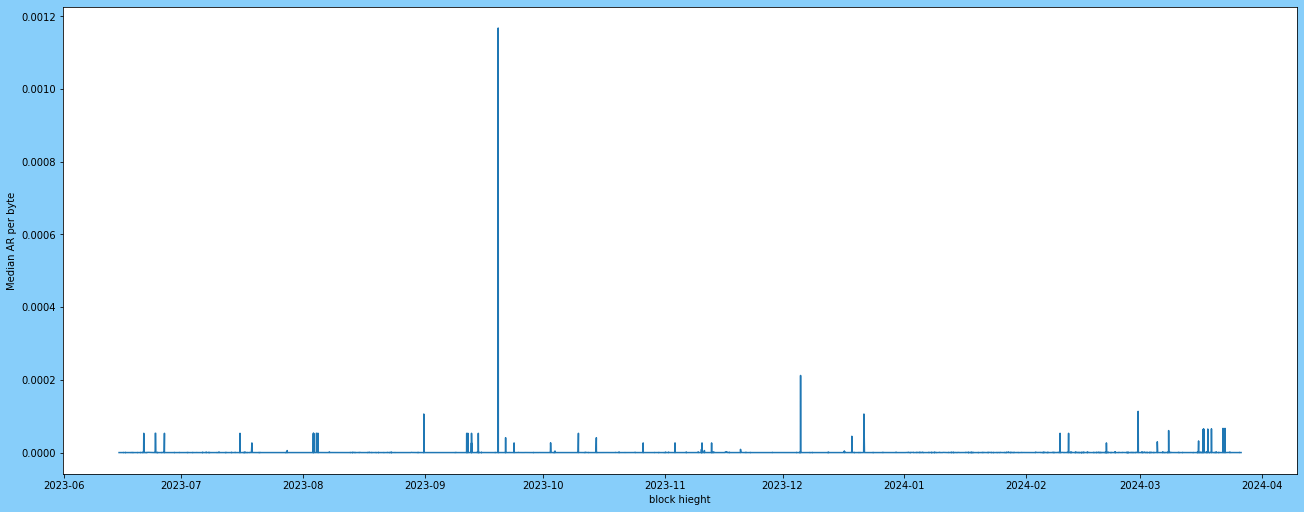

In [103]:
# create a plot figure with a single axis
fig = plt.figure(figsize=(18, 7), facecolor='lightskyblue', layout='constrained')
ax = fig.add_subplot() 
ax.set_xlabel('block hieght')
ax.set_ylabel('Median AR per byte')
ax.plot(df_compute['timestamp_dt'], df_compute['ar_per_byte'])

In [104]:
# get median by month - default not scientific notation
pd.options.display.float_format = '{:.10f}'.format
print(df_transactions.groupby([df_transactions['timestamp_dt'].dt.year, df_transactions['timestamp_dt'].dt.month]).agg({'ar_per_byte': 'median', 'hash': 'count'}))
pd.options.display.float_format = None

                           ar_per_byte    hash
timestamp_dt timestamp_dt                     
2023         6            0.0000000084   19343
             7            0.0000000368   43526
             8            0.0000000717   58156
             9            0.0000000154   15032
             10           0.0000000146   14611
             11           0.0000000087   23056
             12           0.0000000217   34839
2024         1            0.0000001011  130700
             2            0.0000000838  109736
             3            0.0000000245   52684


In [105]:
# get tx data size distribution mean and one standard deviation
mean_bytes = df_transactions['data_size_bytes'].mean()
std_dev = df_transactions['data_size_bytes'].std()

print(f"mean: {mean_bytes}")
print(f"upper bound: {mean_bytes + std_dev}")
print(f"lower bound: {mean_bytes - std_dev}")

mean: 3312404.524175625
upper bound: 52624356.23485738
lower bound: -45999547.18650614


In [106]:
# get all txs within a small MB range
lower_bound_mb = (2**20)*2
upper_bound_mb = (2**20)*10
df_transactions_sample = df_transactions[(df_transactions['data_size_bytes']>=lower_bound_mb) & (df_transactions['data_size_bytes']<=upper_bound_mb)]
df_transactions_sample = df_transactions_sample.sort_values(by='timestamp_dt', ascending=False)
df_transactions_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21491 entries, 467506 to 478901
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   hash             21491 non-null  object        
 1   height           21491 non-null  int64         
 2   timestamp        21491 non-null  int64         
 3   ar_fee           21491 non-null  float64       
 4   data_size_bytes  21491 non-null  float64       
 5   ar_per_mb        21491 non-null  float64       
 6   ar_per_gb        21491 non-null  float64       
 7   timestamp_dt     21491 non-null  datetime64[ns]
 8   data_size_kb     21491 non-null  float64       
 9   data_size_mb     21491 non-null  float64       
 10  data_size_gb     21491 non-null  float64       
 11  ar_per_byte      21491 non-null  float64       
 12  ar_per_kb        21491 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 2.3+ MB


Text(0.05, 0.95, '$\\mathrm{mean}=0.94$')

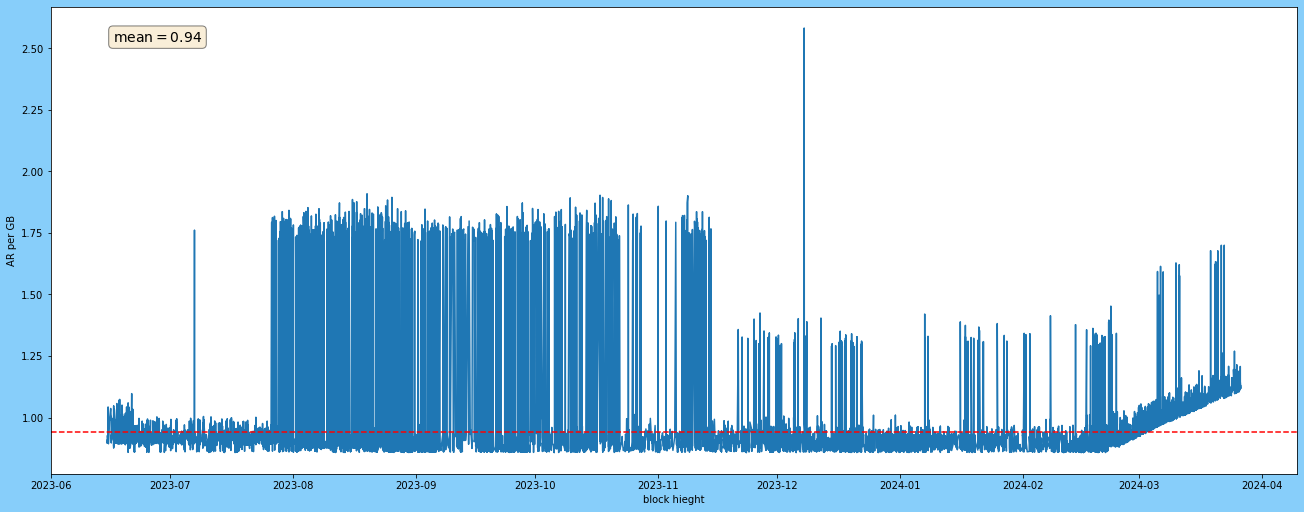

In [107]:
# plot small MB range over time - include a mean line
fig = plt.figure(figsize=(18, 7), facecolor='lightskyblue', layout='constrained')
ax = fig.add_subplot() 
ax.set_xlabel('block hieght')
ax.set_ylabel('AR per GB')
ax.plot(df_transactions_sample['timestamp_dt'], df_transactions_sample['ar_per_gb'])

# add horizontal line at mean value of y
mean_ar_per_gb = np.nanmean(df_transactions_sample['ar_per_gb'])
ax.axhline(y=mean_ar_per_gb, color='red', linestyle='--')

# print the mean value for the reader
textstr = r'$\mathrm{mean}=%.2f$' % (mean_ar_per_gb, )

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

In [83]:
# save an image for readers
fig.savefig(f"{wd_path}/ar_per_gb.png")